In this notebook we perform experiments about the capabilities of LLMs of understanding the legality of moves in board games. 

We focus on the board game Chef's Hat (https://whisperproject.eu/chefshat). The rulebook is available at (https://github.com/pablovin/ChefsHatGYM/blob/master/gitImages/RulebookMenuv08.pdf).

In particular, the players have agency only on the first two phases of each round, and most of the decisions take in place during the second phase, which is the focus of this project work.

In this phase, players can either or play a hand of cards; the played cards must be played on top the cards already present on the board, and all of the cards must have the same value, which must be lower than the value of cards on the board. Moreover, it is not possible to play less cards than the amount of cards that are already on the board. Jokers can replace any card when played on the board, and any card can be put on top of them.

# Importing and cleaning data

We begin by creating our dataframe:

In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import torch
import networkx as nx
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig  

In [2]:
random_state = 42

with open('Dataset.pkl', 'rb') as f:
    data = pickle.load(f)

C:\Users\alfio\AppData\Local\Temp\ipykernel_5528\889859660.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


We use the Hamming distance in order to measures (dis)similarity between instances.

In [3]:
def hamming(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))   

In [4]:
def IoU_lists(s1: list[str], s2: list[str]) -> float:
    set1, set2 = set(s1), set(s2)
    return len(set1 & set2) / len(set1 | set2)

We inspect the attributes of the dataset; we will focus only on the "DISCARD" actions.

In [5]:
print(data.columns)
data

Index(['Match', 'Round', 'Agent_Names', 'Source', 'Action_Type',
       'Action_Description', 'Player_Finished', 'Player_Hands', 'Board_Before',
       'Board_After', 'Possible_Actions', 'Current_Roles', 'Match_Score',
       'Game_Score', 'Game_Performance_Score'],
      dtype='object')


Match  Round  \
2024-11-21_15:03:51.314611      0      0   
2024-11-21_15:03:51.314611      1      0   
2024-11-21_15:03:51.315609      1      0   
2024-11-21_15:03:51.327717      1      1   
2024-11-21_15:03:51.336602      1      1   
...                           ...    ...   
2024-11-21_15:06:08.055500    100     26   
2024-11-21_15:06:08.067496    100     26   
2024-11-21_15:06:08.070494    100     26   
2024-11-21_15:06:08.341109    100     26   
2024-11-21_15:06:08.345109    100     26   

                                                             Agent_Names  \
2024-11-21_15:03:51.314611  [RANDOM_01, RANDOM_02, RANDOM_03, RANDOM_04]   
2024-11-21_15:03:51.314611                                           NaN   
2024-11-21_15:03:51.315609                                           NaN   
2024-11-21_15:03:51.327717                                           NaN   
2024-11-21_15:03:51.336602                                           NaN   
...                                                                  ...   
2024-11-21_15:06:08.055500                                           NaN   
2024-11-21_15:06:08.067496                                           NaN   
2024-11-21_15:06:08.070494                                           NaN   
2024-11-21_15:06:08.341109                                           NaN   
2024-11-21_15:06:08.345109                                           NaN   

                               Source       Action_Type Action_Description  \
2024-11-21_15:03:51.314611     SYSTEM  START_EXPERIMENT                NaN   
2024-11-21_15:03:51.314611     SYSTEM         NEW_MATCH                NaN   
2024-11-21_15:03:51.315609     SYSTEM        DEAL_CARDS                NaN   
2024-11-21_15:03:51.327717  RANDOM_01           DISCARD          C11;Q4;J0   
2024-11-21_15:03:51.336602  RANDOM_02           DISCARD               pass   
...                               ...               ...                ...   
2024-11-21_15:06:08.055500  RANDOM_01           DISCARD               pass   
2024-11-21_15:06:08.067496  RANDOM_02           DISCARD           C8;Q1;J0   
2024-11-21_15:06:08.070494  RANDOM_02     DECLARE_PIZZA                NaN   
2024-11-21_15:06:08.341109     SYSTEM         END_MATCH                NaN   
2024-11-21_15:06:08.345109     SYSTEM    END_EXPERIMENT                NaN   

                           Player_Finished  \
2024-11-21_15:03:51.314611             NaN   
2024-11-21_15:03:51.314611             NaN   
2024-11-21_15:03:51.315609             NaN   
2024-11-21_15:03:51.327717             0.0   
2024-11-21_15:03:51.336602           False   
...                                    ...   
2024-11-21_15:06:08.055500           False   
2024-11-21_15:06:08.067496            True   
2024-11-21_15:06:08.070494             NaN   
2024-11-21_15:06:08.341109             NaN   
2024-11-21_15:06:08.345109             NaN   

                                                                 Player_Hands  \
2024-11-21_15:03:51.314611                                                NaN   
2024-11-21_15:03:51.314611                                                NaN   
2024-11-21_15:03:51.315609  [[3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, 9, 0, 0, 0,...   
2024-11-21_15:03:51.327717  [0, 0, 0, 0, 3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, ...   
2024-11-21_15:03:51.336602  [1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 1...   
...                                                                       ...   
2024-11-21_15:06:08.055500  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.067496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-11-21_15:06:08.070494                                                NaN   
2024-11-21_15:06:08.341109                                                NaN   
2024-11-21_15:06:08.345109                                                NaN   

                                                     Board_Before  \
2024-11-21_15:03:51.314611                            

In [6]:
players = data['Agent_Names'][0]
players

C:\Users\alfio\AppData\Local\Temp\ipykernel_5528\3392628886.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  players = data['Agent_Names'][0]


['RANDOM_01', 'RANDOM_02', 'RANDOM_03', 'RANDOM_04']

In [7]:
data.columns

Index(['Match', 'Round', 'Agent_Names', 'Source', 'Action_Type',
       'Action_Description', 'Player_Finished', 'Player_Hands', 'Board_Before',
       'Board_After', 'Possible_Actions', 'Current_Roles', 'Match_Score',
       'Game_Score', 'Game_Performance_Score'],
      dtype='object')

In [8]:
data_refactored = data[(data['Match'] > 0) & (data['Round'] > 0) & (data['Action_Type'] == 'DISCARD')][['Match', 'Action_Description', 'Player_Hands', 'Board_Before', 'Possible_Actions']]

data_refactored



Match Action_Description  \
2024-11-21_15:03:51.327717      1          C11;Q4;J0   
2024-11-21_15:03:51.336602      1               pass   
2024-11-21_15:03:51.346670      1               pass   
2024-11-21_15:03:51.356687      1          C10;Q4;J0   
2024-11-21_15:03:51.365671      1           C9;Q4;J0   
...                           ...                ...   
2024-11-21_15:06:08.018273    100               pass   
2024-11-21_15:06:08.028495    100               pass   
2024-11-21_15:06:08.036495    100          C10;Q1;J0   
2024-11-21_15:06:08.055500    100               pass   
2024-11-21_15:06:08.067496    100           C8;Q1;J0   

                                                                 Player_Hands  \
2024-11-21_15:03:51.327717  [0, 0, 0, 0, 3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, ...   
2024-11-21_15:03:51.336602  [1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 1...   
2024-11-21_15:03:51.346670  [2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 1...   
2024-11-21_15:03:51.356687  [0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 9, 9, 10, 10...   
2024-11-21_15:03:51.365671  [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 7, 8, 8, ...   
...                                                                       ...   
2024-11-21_15:06:08.018273  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.028495  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.036495  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.055500  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.067496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                     Board_Before  \
2024-11-21_15:03:51.327717     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.336602  [11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.346670  [11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.356687  [11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.365671  [10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0]   
...                                                           ...   
2024-11-21_15:06:08.018273      [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.028495     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.036495     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.055500     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.067496     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                                             Possible_Actions  
2024-11-21_15:03:51.327717  [C11;Q1;J0, C11;Q1;J1, C11;Q2;J0, C11;Q2;J1, C...  
2024-11-21_15:03:51.336602                                             [pass]  
2024-11-21_15:03:51.346670                                   [C8;Q4;J0, pass]  
2024-11-21_15:03:51.356687  [C10;Q3;J1, C10;Q4;J0, C10;Q4;J1, C10;Q5;J0, C...  
2024-11-21_15:03:51.365671     [C8;Q3;J1, C9;Q3;J1, C9;Q4;J0, C9;Q4;J1, pass]  
...                                                                       ...  
2024-11-21_15:06:08.018273                                             [pass]  
2024-11-21_15:06:08.028495                                   [C8;Q1;J0, pass]  
2024-11-21_15:06:08.036495                       [C10;Q1;J0, C11;Q1;J0, pass]  
2024-11-21_15:06:08.055500                                  [C11;Q1;J0, pass]  
2024-11-21_15:06:08.067496                                   [C8;Q1;J0, pass]  

[9844 rows x 5 columns]

In data_refactored, Player_Hands lists the cards that remain in hand AFTER the player has taken the action described in Action_Description.
 
We want to restore the correct player hand so that the Possible_actions column refers to the current player hand and board.

In [9]:
Action_Description_Refactored = data[(data['Match'] > 0) & (data['Round'] > 0) & (data['Action_Type'] == 'DISCARD')]['Action_Description']

New_Action_Description = []

for i in Action_Description_Refactored:
    if i != 'pass':
        actionlist = i.split(';')
    else:
        actionlist = i
    New_Action_Description.append(actionlist)

data_refactored['Action_Description'] = New_Action_Description


In [10]:
Player_Hand_Refactored = []

for i in range(len(data_refactored)):
        newel = list(data_refactored['Player_Hands'][i])
        if data_refactored['Action_Description'][i] != 'pass':
                number = int(data_refactored['Action_Description'][i][0][1:])
                quantity = int(data_refactored['Action_Description'][i][1][1:])
                jolly = int(data_refactored['Action_Description'][i][2][1:])
                for k in range(quantity):
                        newel[newel.index(0)] = number
                for j in range(jolly):
                        newel[newel.index(0)] = 12
        newel.sort(reverse = False)
        newel = [int(i) for i in newel]
        Player_Hand_Refactored.append(newel)

data_refactored['Player_Hands'] = Player_Hand_Refactored
data_refactored

C:\Users\alfio\AppData\Local\Temp\ipykernel_5528\666179860.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  newel = list(data_refactored['Player_Hands'][i])
C:\Users\alfio\AppData\Local\Temp\ipykernel_5528\666179860.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data_refactored['Action_Description'][i] != 'pass':
C:\Users\alfio\AppData\Local\Temp\ipykernel_5528\666179860.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

Match Action_Description  \
2024-11-21_15:03:51.327717      1      [C11, Q4, J0]   
2024-11-21_15:03:51.336602      1               pass   
2024-11-21_15:03:51.346670      1               pass   
2024-11-21_15:03:51.356687      1      [C10, Q4, J0]   
2024-11-21_15:03:51.365671      1       [C9, Q4, J0]   
...                           ...                ...   
2024-11-21_15:06:08.018273    100               pass   
2024-11-21_15:06:08.028495    100               pass   
2024-11-21_15:06:08.036495    100      [C10, Q1, J0]   
2024-11-21_15:06:08.055500    100               pass   
2024-11-21_15:06:08.067496    100       [C8, Q1, J0]   

                                                                 Player_Hands  \
2024-11-21_15:03:51.327717  [3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, 9, 11, 11, 1...   
2024-11-21_15:03:51.336602  [1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 1...   
2024-11-21_15:03:51.346670  [2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 1...   
2024-11-21_15:03:51.356687  [2, 3, 4, 4, 6, 6, 7, 9, 9, 10, 10, 10, 10, 10...   
2024-11-21_15:03:51.365671  [0, 0, 0, 0, 3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, ...   
...                                                                       ...   
2024-11-21_15:06:08.018273  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.028495  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.036495  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.055500  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:08.067496  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                     Board_Before  \
2024-11-21_15:03:51.327717     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.336602  [11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.346670  [11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.356687  [11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:03:51.365671  [10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0]   
...                                                           ...   
2024-11-21_15:06:08.018273      [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.028495     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.036495     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.055500     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2024-11-21_15:06:08.067496     [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                                             Possible_Actions  
2024-11-21_15:03:51.327717  [C11;Q1;J0, C11;Q1;J1, C11;Q2;J0, C11;Q2;J1, C...  
2024-11-21_15:03:51.336602                                             [pass]  
2024-11-21_15:03:51.346670                                   [C8;Q4;J0, pass]  
2024-11-21_15:03:51.356687  [C10;Q3;J1, C10;Q4;J0, C10;Q4;J1, C10;Q5;J0, C...  
2024-11-21_15:03:51.365671     [C8;Q3;J1, C9;Q3;J1, C9;Q4;J0, C9;Q4;J1, pass]  
...                                                                       ...  
2024-11-21_15:06:08.018273                                             [pass]  
2024-11-21_15:06:08.028495                                   [C8;Q1;J0, pass]  
2024-11-21_15:06:08.036495                       [C10;Q1;J0, C11;Q1;J0, pass]  
2024-11-21_15:06:08.055500                                  [C11;Q1;J0, pass]  
2024-11-21_15:06:08.067496                                   [C8;Q1;J0, pass]  

[9844 rows x 5 columns]

We now select only the unique pairs of (player_hand, board_state):

In [11]:
data_refactored['Player_Hands'] = data_refactored['Player_Hands'].apply(tuple)
data_refactored['Board_Before'] = data_refactored['Board_Before'].apply(tuple)

data_refactored_unique = data_refactored.drop_duplicates(subset = ['Player_Hands', 'Board_Before'])
data_refactored_unique

Match Action_Description  \
2024-11-21_15:03:51.327717      1      [C11, Q4, J0]   
2024-11-21_15:03:51.336602      1               pass   
2024-11-21_15:03:51.346670      1               pass   
2024-11-21_15:03:51.356687      1      [C10, Q4, J0]   
2024-11-21_15:03:51.365671      1       [C9, Q4, J0]   
...                           ...                ...   
2024-11-21_15:06:07.788984    100               pass   
2024-11-21_15:06:07.856173    100               pass   
2024-11-21_15:06:07.891175    100      [C11, Q1, J0]   
2024-11-21_15:06:07.904180    100      [C11, Q2, J0]   
2024-11-21_15:06:07.942268    100      [C10, Q3, J0]   

                                                                 Player_Hands  \
2024-11-21_15:03:51.327717  (3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, 9, 11, 11, 1...   
2024-11-21_15:03:51.336602  (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 1...   
2024-11-21_15:03:51.346670  (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 1...   
2024-11-21_15:03:51.356687  (2, 3, 4, 4, 6, 6, 7, 9, 9, 10, 10, 10, 10, 10...   
2024-11-21_15:03:51.365671  (0, 0, 0, 0, 3, 3, 5, 7, 7, 8, 8, 8, 9, 9, 9, ...   
...                                                                       ...   
2024-11-21_15:06:07.788984  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2024-11-21_15:06:07.856173  (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11...   
2024-11-21_15:06:07.891175  (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11...   
2024-11-21_15:06:07.904180  (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10,...   
2024-11-21_15:06:07.942268  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10...   

                                                     Board_Before  \
2024-11-21_15:03:51.327717     (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:03:51.336602  (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:03:51.346670  (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:03:51.356687  (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:03:51.365671  (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)   
...                                                           ...   
2024-11-21_15:06:07.788984     (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:06:07.856173      (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:06:07.891175     (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:06:07.904180     (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2024-11-21_15:06:07.942268     (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   

                                                             Possible_Actions  
2024-11-21_15:03:51.327717  [C11;Q1;J0, C11;Q1;J1, C11;Q2;J0, C11;Q2;J1, C...  
2024-11-21_15:03:51.336602                                             [pass]  
2024-11-21_15:03:51.346670                                   [C8;Q4;J0, pass]  
2024-11-21_15:03:51.356687  [C10;Q3;J1, C10;Q4;J0, C10;Q4;J1, C10;Q5;J0, C...  
2024-11-21_15:03:51.365671     [C8;Q3;J1, C9;Q3;J1, C9;Q4;J0, C9;Q4;J1, pass]  
...                                                                       ...  
2024-11-21_15:06:07.788984                         [C7;Q1;J0, C7;Q2;J0, pass]  
2024-11-21_15:06:07.856173                                             [pass]  
2024-11-21_15:06:07.891175  [C8;Q1;J0, C9;Q1;J0, C10;Q1;J0, C10;Q2;J0, C10...  
2024-11-21_15:06:07.904180  [C8;Q1;J0, C9;Q1;J0, C10;Q1;J0, C10;Q2;J0, C10...  
2024-11-21_15:06:07.942268  [C8;Q1;J0, C9;Q1;J0, C10;Q1;J0, C10;Q2;J0, C10...  

[7819 rows x 5 columns]

In [12]:
balanced_df_train = data_refactored_unique[(data_refactored_unique['Match'] <= 97)]
balanced_df_train_shuffled = balanced_df_train.sample(frac=1, random_state = random_state).reset_index(drop=True) #The other random_states in the .sample() methods shall be left fixed in order to guarantee that the test set remains the same
balanced_df_train_shuffled

Match Action_Description  \
0        90               pass   
1        12       [C7, Q2, J0]   
2        79      [C10, Q4, J0]   
3        17               pass   
4         6               pass   
...     ...                ...   
7593     65       [C3, Q1, J0]   
7594     65       [C9, Q2, J0]   
7595     67               pass   
7596     10               pass   
7597     93               pass   

                                           Player_Hands  \
0     (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, ...   
1     (0, 0, 0, 0, 0, 1, 4, 6, 7, 7, 8, 9, 9, 10, 10...   
2     (0, 0, 0, 4, 4, 5, 6, 7, 7, 8, 8, 9, 10, 10, 1...   
3     (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, ...   
4     (0, 0, 0, 0, 0, 5, 6, 6, 7, 8, 9, 9, 9, 11, 11...   
...                                                 ...   
7593  (0, 0, 0, 0, 0, 0, 3, 3, 6, 8, 8, 9, 9, 9, 10,...   
7594  (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 8, 9, 9, 10,...   
7595  (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 9, 9, 10, 11...   
7596  (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, ...   
7597  (0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10, 10, 11, 11,...   

                             Board_Before  \
0       (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
1     (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2     (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
3       (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
4       (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
...                                   ...   
7593    (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
7594  (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
7595    (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
7596    (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
7597    (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)   

                                       Possible_Actions  
0                                                [pass]  
1                            [C7;Q2;J0, C9;Q2;J0, pass]  
2     [C4;Q2;J0, C7;Q2;J0, C8;Q2;J0, C10;Q2;J0, C10;...  
3                                                [pass]  
4                                      [C6;Q2;J0, pass]  
...                                                 ...  
7593               [C3;Q1;J0, C3;Q2;J0, C6;Q1;J0, pass]  
7594                        [C9;Q2;J0, C10;Q2;J0, pass]  
7595                                   [C3;Q1;J0, pass]  
7596                                   [C7;Q2;J0, pass]  
7597                                             [pass]  

[7598 rows x 5 columns]

In [13]:
balanced_df_test = data_refactored_unique[(data_refactored_unique['Match'] > 97)]
balanced_df_test_shuffled = balanced_df_test.sample(frac=1, random_state = 42).reset_index(drop=True)
balanced_df_test_shuffled

Match Action_Description  \
0       99               pass   
1       99               pass   
2       99               pass   
3      100       [C9, Q3, J0]   
4       98       [C8, Q1, J0]   
..     ...                ...   
216     99               pass   
217     98       [C9, Q1, J0]   
218     99       [C3, Q1, J0]   
219    100               pass   
220     99       [C7, Q1, J0]   

                                          Player_Hands  \
0    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10...   
2    (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, ...   
3    (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, ...   
4    (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10,...   
..                                                 ...   
216  (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 1...   
217  (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, ...   
218  (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 1...   
219  (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 1...   
220  (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 1...   

                            Board_Before  \
0      (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
1    (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
2      (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
3     (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
4      (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
..                                   ...   
216    (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
217   (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
218   (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
219    (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
220   (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   

                                      Possible_Actions  
0                                               [pass]  
1                         [C10;Q2;J0, C10;Q3;J0, pass]  
2                                               [pass]  
3    [C6;Q1;J0, C8;Q1;J0, C8;Q2;J0, C9;Q1;J0, C9;Q2...  
4    [C3;Q1;J0, C3;Q2;J0, C4;Q1;J0, C4;Q2;J0, C4;Q3...  
..                                                 ...  
216                                             [pass]  
217  [C5;Q1;J0, C5;Q2;J0, C5;Q3;J0, C6;Q1;J0, C6;Q2...  
218  [C1;Q1;J0, C3;Q1;J0, C4;Q1;J0, C7;Q1;J0, C9;Q1...  
219                                             [pass]  
220  [C6;Q1;J0, C7;Q1;J0, C7;Q2;J0, C8;Q1;J0, C8;Q2...  

[221 rows x 5 columns]

# Experiments

We perform experiments with the Llama-3.1-8B-Instruct model from Huggingface. We adopt 4-bit quantization for improving speed and performances. In all of the experiments we include three settings.

In the first case we do not provide any explanation about the semantics of the input and just ask the model to complete the query based on the provided examples.

In the second case we provide a basic explanation of the input, without references to the rules of the game.

Last, we give a full explanation about the semantics of the input, the rules of the game, and include known techniques of prompt engineering.

We evaluate results according to several metrics: all_moves_accuracy (the fraction of instances for which the full correct list of legal moves is returned), TP (the number of correctly identified legal moves), FP (the number of illegal moves returned), FN (the legal moves which are not returned by the model) and IoU_lists (a variant of Intersection over Union for lists)

In [14]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16,
                  "quantization_config": {"load_in_4bit": True}},
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


## Experiment 3: Graph-Based Example Selection

In this last experiment we test the effectiveness of Graph-based example retrieval in the in-context learning setting.

At first, we construct the "training set graph": in this graph nodes are examples from the training set, and edges are constructed between nodes when a similarity score between the examples is greater than a threshold T (or the dissimilarity or distance is below a threshold T).

At test time, for each test instance we extract a subgraph of the constructed larger graph by only selecting nodes that represent examples that are close to the test instance, and returning examples according to a suitable function of the graph (in this case we return the top 5/10/15 nodes according to the PageRank metric (see the notebook for details)).

Note that at inference time there is no need to rebuild the full training set graph; instead it is equivalent and might be more convenient to directly construct the subgraph by only considering the closest nodes to the prompt instance.

Another thing to consider is that for this method to differ from the previous KNN approach, the number of nodes belonging to the extracted subgraph should be (somewhat considerably) greater than 5/10/15 (in general, K) respectively.

In [15]:
balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before']

(0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 9,
 11,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0)

In [16]:
# "Training set graph" construction:

subgraph_threshold = 3 #This "resolution" threshold can be modified

Training_graph = nx.Graph()

for i in range(len(balanced_df_train_shuffled)):
    Training_graph.add_node(i)
    for j in range(i):
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_train_shuffled.iloc[i]['Player_Hands'] + balanced_df_train_shuffled.iloc[i]['Board_Before']) <= subgraph_threshold:
            Training_graph.add_edge(i,j)

In [17]:
len(Training_graph.edges())

272793

In [18]:
Training_graph.degree

DegreeView({0: 361, 1: 3, 2: 3, 3: 140, 4: 2, 5: 1, 6: 0, 7: 6, 8: 3, 9: 454, 10: 7, 11: 669, 12: 144, 13: 126, 14: 42, 15: 67, 16: 5, 17: 37, 18: 20, 19: 7, 20: 334, 21: 0, 22: 212, 23: 58, 24: 13, 25: 395, 26: 2, 27: 0, 28: 18, 29: 341, 30: 149, 31: 70, 32: 363, 33: 6, 34: 143, 35: 24, 36: 31, 37: 202, 38: 11, 39: 57, 40: 0, 41: 8, 42: 0, 43: 1, 44: 3, 45: 1, 46: 378, 47: 25, 48: 4, 49: 478, 50: 139, 51: 152, 52: 299, 53: 278, 54: 9, 55: 178, 56: 358, 57: 45, 58: 197, 59: 5, 60: 12, 61: 2, 62: 0, 63: 12, 64: 166, 65: 1, 66: 497, 67: 30, 68: 3, 69: 144, 70: 7, 71: 68, 72: 19, 73: 7, 74: 182, 75: 60, 76: 6, 77: 314, 78: 295, 79: 1, 80: 0, 81: 20, 82: 2, 83: 3, 84: 1, 85: 456, 86: 19, 87: 15, 88: 5, 89: 11, 90: 4, 91: 10, 92: 1, 93: 475, 94: 264, 95: 6, 96: 18, 97: 123, 98: 6, 99: 3, 100: 8, 101: 508, 102: 330, 103: 215, 104: 459, 105: 2, 106: 12, 107: 280, 108: 156, 109: 58, 110: 8, 111: 30, 112: 3, 113: 84, 114: 386, 115: 36, 116: 4, 117: 20, 118: 74, 119: 61, 120: 3, 121: 5, 122: 15,

In [19]:
distances = []

for i in range(len(balanced_df_test_shuffled)):
    count = 0
    for j in range(len(balanced_df_train_shuffled)):
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) <= 8:
            count+=1
    distances.append(count)

print(min(distances), max(distances), sum(distances)/len(distances))

1 4041 1470.2488687782804


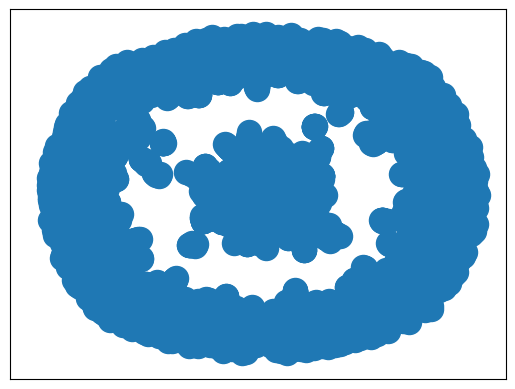

In [20]:
nx.draw_networkx(Training_graph, with_labels = False)

### No explanations provided

#### 5 examples

In [21]:
#### 5 EXAMPLES, NO DESCRIPTION OF THE TASK

count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:5] #select top 5 nodes according to pagerank metric
    
    #QUI
    a = 7
    while(len(sorted_pagerank) < 5):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:5]
        a += 1


    #Building examples:

    text_examples = ''

    for k in range(5):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': 'Complete the following text. Only add the text that comes after "B:"'},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C9;Q1;J0', 'C11;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C10;Q2;J0'), np.str_('C10;Q3;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 3
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']


['C6;Q0;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C7;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C8;Q7;J0', 'C9;Q7;J0', 'C9;Q8;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C5;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 1
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C6;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 2, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']


['C5;Q7;J7', 'C7;Q7;J7', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 2
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']


['C0;Q4;J0', 'C1;Q4;J0', 'C2;Q4;J0', 'C3;Q4;J0', 'C6;Q4;J0', 'C7;Q4;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C7;Q4;J0', 'C7;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C4;Q1;J0'), np.str_('C5;Q1;J0'), np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C6;Q3;J0', 'C6;Q3;J1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q8;J8', 'C9;Q8;J8', 'C10;Q8;J8', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q2;J0', 'C10;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 2, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C8;Q1;J0'), np.str_('C8;Q2;J0'), np.str_('pass')] 

TP: 4
FN: 0
FP: 1
IoU: 0.8 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 5
IoU: 0.375 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']


['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('C6;Q2;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 5
IoU

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 9, 9, 9, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'pass']


['C3;Q2;J0', 'C3;Q3;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 9
IoU: 0.1 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C6;Q2;J0'), np.str_('C7;Q1;J0'), np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('C5;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('C11;Q1;J0'), np.str_('C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('C10;Q1;J0'), np.str_('pass')] 

TP: 5
FN: 0
FP: 0
IoU: 1.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C3;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
F

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 5
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0']
[np.str_('C6;Q1;J0'), np.str_('C6;Q2;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('C10;Q1;J0'),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']


['C5;Q1;J0', 'C5;Q1;J1', 'pass']
[np.str_('C2;Q1;J0'), np.str_('C2;Q1;J1'), np.str_('pass')]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q2;J5', 'C5;Q3;J5', 'C6;Q1;J5', 'C6;Q2;J5', 'C9;Q1;J5', 'C9;Q2;J5', 'C10;Q1;J5', 'pass']
[np.str_('C5;Q2;J0'), np.str_('C5;Q3;J0'), np.str_('C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (1, 3, 3, 5, 6, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q3;J0', 'C8;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (1, 2, 2, 3, 5, 6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 9, 10), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q4;J0', 'C9;Q5;J0', 'pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['fail']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 1
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 5, 6, 6, 6, 6, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 6, 6, 6, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (11, 11, 11, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J0', 'C9;Q4;J0', 'pass']

A: (3, 4, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 12, 12, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J1', 'C10;Q5;J0', 'C10;Q5;J1', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']


['C7;Q4;J0', 'C8;Q4;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('pass')] 

TP: 5
FN

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']


['C6;Q3;J0', 'C7;Q3;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q3;J0', 'pass']
[np.str_('C3;Q2;J0'), np.str_('C6;Q2;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 1
FN: 3
FP: 5
IoU: 0.1111111111111111 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 6, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 3, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C7;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q3;J0', 'pass']

A: (0, 0, 5, 6, 6, 7, 7, 7, 9, 9, 9, 10, 10, 10, 11, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J2', 'C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'pass']

A: (0, 2, 5, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'C7;Q4;J0', 'C7;Q4;J1', 'C7;Q4;J2', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']


['C11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']

A: (0, 2, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']


['C4;Q1;J0', 'pass']
[np.str_('C3;Q1;J0'), np.str_('C3;Q1;J1'), np.str_('C3;Q2;J0'), np.str_('C3;Q2;J1'), np.str_('pass')] 

TP: 1
FN: 4
FP: 1
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']


['C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C6;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 3, 3, 4, 4, 5, 6, 6, 7, 7, 7, 8, 9, 10, 11), (12, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 1, 3, 3, 4, 4, 4, 5, 6, 7, 9, 9, 9, 10, 10, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']


['C4;Q3;J0', 'pass']
[np.str_('C4;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 0
IoU: 1.0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('C2;Q1;J0'), np.str_('C4;Q1;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 5
IoU: 0.375 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 8, 8, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q2;J0', 'C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('C8;Q3;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 4
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C1;Q1;J0', 'C1;Q2;J0', 'C1;Q3;J0', 'C1;Q4

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C9;Q1;J0', 'C11;Q1;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('C10;Q1;J0'), np.str_('C10;Q2;J0'), np.str_('pass')] 

TP: 5
FN: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q2;J1', 'C7;Q3;J1', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C2;Q2;J0', 'C6;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C5;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 2
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C1;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']


['C4;Q2;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q1;J0', 'pass']
[np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 4
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 4
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 6, 6, 7, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 4, 7, 7, 8, 8, 8, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']


['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']


['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']
[np.str_('C8;Q3;J0'), np.str_('C10;Q3;J0'), np.str_('C10;Q4;J0'), np.str_('pass')] 

TP: 2
FN: 2
FP: 3
IoU: 0.2857142857142857 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C8;Q1;J0'), np.str_('C8;Q2;J0'), np.str_('C9;Q1;J0'), np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C9;Q1;J0'), np.str_('C10;Q1;J0'), np.str_('C10;Q2;J0'), np.str_('C11;Q1;J0'), 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C6;Q3;J0', 'C6;Q3;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C7;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('C8;Q2;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 5
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 2
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 7, 7, 8, 8, 9, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 1, 2, 3, 3, 5, 6, 7, 8, 9, 9, 11, 11, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C6;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 1
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 1, 2, 3, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q4;J0', 'pass']

A: (0, 0, 0, 0, 3, 4, 6, 7, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q3;J0', 'C9;Q3;J0', 'pass']

A: (1, 3, 3, 4, 5, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C8;Q4;J0', 'pass']
[np.str_('C8;Q4;J0'), np.str_('C8;Q5;J0'), np.str_('pass')] 

TP: 2
FN: 1
FP: 0
IoU: 0.6666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']


['C0;Q0;J1', 'C0;Q0;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'pass']
[np.str_('C4;Q1;J0'), np.str_('C5;Q1;J0'), np.str_('pass')] 

TP: 1
FN: 2
FP: 4
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']


['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('C2;Q1;J0'), np.str_('C4;Q1;J0'), np.str_('C5;Q1;J0'), np.str_('C6;Q1;J0'), np.str_('C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 5
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q2;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'C7;Q8;J0', 'C7;Q9;J0', 'C7;Q10;J0', 'C7;Q11;J0', 'C7;Q12;J0', 'C7;Q13;J0', 'C7;Q14;J0', 'C7;Q15;J0', 'C7;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 7, 7, 9, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']


['C7;Q2;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C9;Q1;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'C8;Q3;J0', 'C9;Q3;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 6
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 2, 3, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q3;J0', 'C9;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q2;J0', 'C5;Q2;J0', 'pass']

A: (2, 2, 3, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q3;J0', 'C5;Q3;J1', 'C5;Q3;J2', 'C6;Q3;J0', 'C6;Q3;J1', 'C6;Q3;J2', 'C9;Q3;J0', 'C9;Q3;J1', 'C9;Q3;J2', 'C10;Q3;J0', 'C10;Q3;J1', 'C10;Q3;J2', 'pass']
[np.str_('C5;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 11
IoU: 0.15384615384615385 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C6;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'pass']
[np.str_('C7;Q2;J0'), np.str_('C8;Q2;J0'), np.str_('C8;Q3;J0'), np.str_('pass')] 

TP: 1
FN: 3
FP: 2
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C9;Q3;J0', 'pass']

A: (1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 8, 9, 10, 10, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 4, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 9, 10, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C9;Q3;J0', 'C10;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J0', 'pass']


['C4;Q3;J0', 'C6;Q3;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']


['C4;Q2;J0', 'C4;Q3;J0', 'pass']
[np.str_('C4;Q3;J0'), np.str_('C4;Q4;J0'), np.str_('pass')] 

TP: 2
FN: 1
FP: 1
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (5, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 12), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C5;Q3;J0', 'C5;Q3;J1', 'C6;Q1;J1', 'pass']

A: (5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 12), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J1', 'C6;Q2;J1', 'C6;Q3;J0', 'C6;Q3;J1', 'pass']


['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C5;Q3;J0', 'C5;Q3;J1', 'C6;Q1;J1', 'pass']
[np.str_('C5;Q2;J1')

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q6;J8', 'C8;Q6;J8', 'C9;Q6;J8', 'C9;Q7;J8', 'C10;Q6;J8', 'C10;Q7;J8', 'C10;Q8;J8', 'C11;Q6;J8', 'C11;Q7;J8', 'C11;Q8;J8', 'C11;Q9;J8', 'C11;Q10;J8', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 5
IoU: 0.375 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('C8;Q1;J0'), np.str_('C9;Q1;J0'), np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']


['C3;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

#### 10 examples

In [22]:
#### 10 EXAMPLES, NO DESCRIPTION OF THE TASK

count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:10] #select top 10 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 10):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:10]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(10):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': 'Complete the following text. Only add the text that comes after "B:"'},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 5, 6, 7, 7, 8, 10, 11, 11, 11), (6, 6, 6, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 2, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (13

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 9, 9, 9, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 6, 8, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 2, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (2, 3, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 5, 6, 6, 6, 6, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 6, 6, 6, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (11, 11, 11, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J0', 'C9;Q4;J0', 'pass']

A: (3, 4, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 12, 12, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J1', 'C10;Q5;J0', 'C10;Q5;J1', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']

A: (4, 4, 7, 7, 8, 8, 8, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 3, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C7;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q3;J0', 'pass']

A: (0, 0, 5, 6, 6, 7, 7, 7, 9, 9, 9, 10, 10, 10, 11, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J2', 'C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'pass']

A: (0, 2, 5, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'C7;Q4;J0', 'C7;Q4;J1', 'C7;Q4;J2', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (2,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']

A: (0, 2, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 3, 3, 4, 6, 6, 7, 8, 10, 10, 10, 11, 11, 11, 11, 12), (4, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 8, 8, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9), (1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 2, 3, 6, 6, 8, 8, 9, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 7, 7, 9, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 5, 6, 8, 8, 8, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 2, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C9;Q3;J0', 'pass']

A: (1, 2, 2, 4, 4, 4, 5, 5, 6, 7, 8, 8, 8, 10, 10, 10, 10), (11, 11, 12, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J0', 'pass']

A: (1, 2, 3, 4, 5, 5, 6, 6, 6, 7, 8, 8, 8, 9, 9, 9, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 11), (11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 8, 9, 10, 10, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 4, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 9, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 3, 4, 4, 5, 5, 6, 7, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

#### 15 examples

In [23]:
#### 15 EXAMPLES, NO DESCRIPTION OF THE TASK

count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 8) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:15] #select top 15 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 15):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 10) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:15]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(15):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': 'Complete the following text. Only add the text that comes after "B:"'},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: [

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (2, 3, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 9, 9, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C10;Q3;J0', 'C10;Q3;J1', 'C10;Q4;J0', 'C10;Q4;J1', 'C0;Q0;J1', 'pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 6, 6, 8, 8, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (13

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5, 6, 8, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 7, 8, 8, 9, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 3, 4, 4, 5, 6, 8, 8, 9, 9, 10, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 4, 5, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C5;Q3;J0', 'C7;Q2;J0', 'pass']

A: (1, 2, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 5, 6, 7, 8, 8, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (1, 3, 3, 5, 7, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 6, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (2, 3, 3, 4, 5, 5, 7, 7, 8, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 7, 7, 8, 10, 10, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9), (1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 3, 3, 6, 6, 6, 6, 7, 8, 9, 9, 10, 10, 11, 11), (8, 8, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 4, 5, 5, 6, 8, 8, 9, 10, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 9, 10, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (10, 10, 10, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 2, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

### Minimal Description

#### 5 examples

In [24]:
#### 5 EXAMPLES, MINIMAL DESCRIPTION OF THE TASK

count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:5] #select top 5 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 5):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:5]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(5):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': '''In the following examples "A" provides two lists. The first list is a description of the cards in hand of a bord game player. The second list is a description of the cards that are already on the board. In both cases a "0" represents a missing card. Then, "B" replies with the full list of the current legal moves according to the description of "A". Complete the text by listing the correct legal moves given the last description from "A". Only add the text that comes after "B:"
'''},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('C10;Q2;J0'), np.str_('C10;Q3;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 4
IoU

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C0;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J1', 'C7;Q2;J1', 'C8;Q1;J1', 'C8;Q2;J1', 'C9;Q1;J1', 'C9;Q2;J1', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C4;C7;J0', 'C4;Q2;J0', 'C6;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C0;Q6;J0', 'C0;Q6;J9', 'C0;Q6;J10', 'C0;Q6;J10', 'C0;Q6;J10', 'C0;Q6;J10', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 2, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;C8;C3;C3;J0', 'C8;C8;C3;C3;J0', 'C9;C3;C3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 2
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;C9;Q1;J0', 'C6;C9;Q2;J0', 'C6;C10;Q1;J0', 'C9;C9;Q1;J0', 'C9;C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C1;Q1;J0', 'C1;Q2;J0', 'C2;Q1;J0', 'C2;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C10;Q1;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;Q4;J0', 'C0;Q5;J0', 'C0;Q6;J0', 'C0;Q7;J0', 'C0;Q8;J0', 'C0;Q9;J0', 'C0;Q10;J0', 'C0;Q11;J0', 'C0;Q12;J0', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C9;D7;J0', 'C10;D7;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C6;Q3;J0', 'C6;Q3;J1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 2, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C8;Q1;J0'), np.str_('C8;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 1
FP: 1
IoU: 0.6 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 5
IoU: 0.375 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']


['pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 0
IoU: 1.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('C6;Q2;J0'), n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 9, 9, 9, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'pass']


['C3;Q2;J0', 'C3;Q3;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 11
IoU: 0.08333333333333333 


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C0;Q6;J0', 'C0;Q6;J7', 'C0;Q6;J9', 'C0;Q6;J9', 'C0;Q7;J6', 'C0;Q7;J6', 'C0;Q7;J9', 'C0;Q7;J9', 'C0;Q9;J6', 'C0;Q9;J6', 'C0;Q9;J7', 'C0;Q9;J7', 'C0;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']


['C2;Q1;J0', 'C2;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;Q4;J0', 'C0;Q5;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C6;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C9;Q6;J0', 'C9;Q7;J0', 'C9;Q8;J0', 'C9;Q9;J0', 'C9;Q10;J0', 'C9;Q11;J0', 'C9;Q12;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C6;Q4;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C10;Q1;J0', 'C11;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C6;Q2;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']


['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']
[np.str_('C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;C5;C5;Q1;J0', 'C5;C5;C5;Q2;J0', 'C5;C5;C6;Q1;J0', 'C5;C5;C6;Q2;J0', 'C5;C6;C6;Q1;J0', 'C5;C6;C6;Q2;J0', 'C5;C9;Q1;J0', 'C5;C9;Q2;J0', 'C5;C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (1, 3, 3, 5, 6, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q3;J0', 'C8;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (1, 2, 2, 3, 5, 6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 9, 10), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q4;J0', 'C9;Q5;J0', 'pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['pass', 'place 10 on 0', 'place 9 on 0', 'place 7 on 0', 'place 6 on 0', 'place 3 on 0', 'place 3 on 0', 'place 6 on 0', 'place 7 on 0', 'place 9 on 0', 'place 10 on 0', 'place 11 on 0', 'place 11 on 0', 'place 11 on 0', 'place 11 on 0', 'place 11 on 0', 'place 11 on 0', 'place 11 on 0']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.142857142

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;Q4;J0', 'C0;Q5;J0', 'C0;Q6;J0', 'C0;Q7;J0', 'C0;Q8;J0', 'C0;Q9;J0', 'C0;Q10;J0', 'C0;Q11;J0', 'C0;Q12;J0', 'C0;Q13;J0', 'C10;Q1;J0', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 5, 6, 6, 6, 6, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 6, 6, 6, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (11, 11, 11, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J0', 'C9;Q4;J0', 'pass']

A: (3, 4, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 12, 12, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J1', 'C10;Q5;J0', 'C10;Q5;J1', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']


['C8;Q4;J0', 'C8;Q4;J1', 'C8;Q5;J0', 'C8;Q5;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 8
IoU: 0.1111111111111111

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('pass')] 

TP: 5
FN

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C3;Q2;J0'), np.str_('C6;Q2;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 4
FN: 0
FP: 6
IoU: 0.4 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 6, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 3, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C7;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q3;J0', 'pass']

A: (0, 0, 5, 6, 6, 7, 7, 7, 9, 9, 9, 10, 10, 10, 11, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J2', 'C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'pass']

A: (0, 2, 5, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'C7;Q4;J0', 'C7;Q4;J1', 'C7;Q4;J2', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']


['C5;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']

A: (0, 2, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']


['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C3;Q1;J0'), np.str_('C3;Q1;J1'), np.str_('C3;Q2;J0'), np.str_('C3;Q2;J1'), np.str_('pass')] 

TP: 2
FN: 3
FP: 4
IoU: 0.2222222222222222 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']


['C0;Q1;J1', 'C0;Q2;J1', 'C0;Q3;J1', 'C0;Q4;J1', 'C0;Q5;J1', 'C4;Q1;J1', 'C7;Q1;J1', 'C9;Q1;J1', 'C9;Q2;J1', 'C9;Q3;J1', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C3;Q1;J0', 'C3;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 3, 3, 4, 4, 5, 6, 6, 7, 7, 7, 8, 9, 10, 11), (12, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 1, 3, 3, 4, 4, 4, 5, 6, 7, 9, 9, 9, 10, 10, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']


['pass']
[np.str_('C4;Q3;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 0
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']
[np.str_('C2;Q1;J0'), np.str_('C4;Q1;J0'), np.str_('pass')] 

TP: 3
FN:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 8, 8, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']
[np.str_('C8;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 3
IoU: 0.4 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;C5;C6;C7;C8;C8;C8;C10;C10;C10;C10;C11;C7;C7;pass']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 1
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C9;Q6;J0', 'C9;Q7;J0', 'C9;Q8;J0', 'C9;Q9;J0', 'C9;Q0;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('C10;Q1;J0'), np.str_('C10;Q2;J0'), np.str_('pass')] 

TP: 5
FN: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C2;Q2;J0', 'C2;Q3;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C0;Q6;J0', 'C6;Q6;J0', 'C10;Q6;J0', 'C10;Q6;J0', 'C10;Q6;J0', 'C11;Q6;J0', 'C11;Q6;J0', 'pass']
[np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C5;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 2
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C1;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']


['C4;Q2;J0', 'C5;Q2;J0', 'C6;Q2;J0', 'pass']
[np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 3
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 12
IoU: 0.076923076

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;C8;Q1;J0', 'C7;C8;Q2;J0', 'C7;C9;Q1;J0', 'C7;C9;Q2;J0', 'C7;C11;Q1;J0', 'C7;C11;Q2;J0', 'C9;C8;Q1;J0', 'C9;C8;Q2;J0', 'C9;C11;Q1;J0', 'C9;C11;Q2;J0', 'pass']
[np.str_('C7;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 6, 6, 7, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 4, 7, 7, 8, 8, 8, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']


['C4;C11;C11;C11;pass']
[np.str_('C8;Q3;J0'), np.str_('C10;Q3;J0'), np.str_('C10;Q4;J0'), np.str_('pass')] 

TP: 0
FN: 4
FP: 1
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C8;Q1;J0'), np.str_('C8;Q2;J0'), np.str_('C9;Q1;J0'), np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C9;Q1;J0'), np.str_('C10;Q1;J0'), np.str_('C10;Q2;J0'), np.str_('C11;Q1;J0'), 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C9;Q3;J0', 'C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C10;Q3;J0', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C6;C6;J0', 'C6;C7;J0', 'C6;C7;J3', 'C6;C7;J9', 'C6;C7;J10', 'C6;Q2;J0', 'C6;Q3;J0', 'C6;Q5;J0', 'C6;Q8;J0', 'C6;Q9;J0', 'C6;Q10;J0', 'C7;C6;J0', 'C7;C6;J3', 'C7;C6;J9', 'C7;C6;J10', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q5;J0', 'C7;Q8;J0', 'C7;Q9;J0', 'C7;Q10;J0', 'C9;C6;J0', 'C9;C6;J3', 'C9;C6;J9', 'C9;C6;J10', 'C9;C7;J0', 'C9;C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C0;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('C8;Q2;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 7
IoU: 0.2222222222222222 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C7;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 3
IoU: 0.4 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 7, 7, 8, 8, 9, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 1, 2, 3, 3, 5, 6, 7, 8, 9, 9, 11, 11, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C3;C4;C6;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 1
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']


['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 1, 2, 3, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q4;J0', 'pass']

A: (0, 0, 0, 0, 3, 4, 6, 7, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q3;J0', 'C9;Q3;J0', 'pass']

A: (1, 3, 3, 4, 5, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']
[np.str_('C8;Q4;J0'), np.str_('C8;Q5;J0'), np.str_('pass')] 

TP: 1
FN: 2
FP: 4
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']


['C0;Q0;J0', 'C0;Q0;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C4;Q1;J0'), np.str_('C5;Q1;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 3
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']


['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']
[np.str_('C2;Q1;J0'), np.str_('C4;Q1;J0'), np.str_('C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']
[np.str_('pass')] 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C9;D6;D6', 'C10;D6;D6', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C5;Q1;J0'), np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 5
FN: 0
FP: 0
IoU: 1.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 7, 7, 9, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']


['pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 0
IoU: 1.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C9;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 2
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 2, 3, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q3;J0', 'C9;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q2;J0', 'C5;Q2;J0', 'pass']

A: (2, 2, 3, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


[" ['C5;Q2;J0", 'C5;Q3;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('C5;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 7
IoU: 0.2222222222222222 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C0;Q6;J0', 'C10;Q6;J0', 'C10;Q10;J0', 'C10;Q10;J10', 'C11;Q6;J0', 'C11;Q10;J0', 'C11;Q10;J10', 'pass

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;C5;Q1', 'C4;C5;Q2', 'C4;C5;Q3', 'C4;C5;Q4', 'C4;C5;J0', 'C4;C5;J1', 'C4;C5;J2', 'C4;C5;J3', 'C4;C5;J4', 'C4;C5;J5', 'C4;C5;J6', 'C4;C5;J7', 'C4;C5;J8', 'C4;C5;J9', 'C4;C5;S0', 'C4;C5;S1', 'C4;C5;S2', 'C4;C5;S3', 'C4;C5;S4', 'C4;C5;S5', 'C4;C5;S6', 'C4;C5;S7', 'C4;C5;S8', 'C4;C5;S9', 'C4;C5;H0', 'C4;C5;H1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q2', 'C6;Q2', 'C6;Q3', 'C7;Q2', 'C7;Q3', 'C8;Q2', 'C8;Q3', 'C8;Q4', 'C10;Q2', 'C10;Q3', 'C11;Q2', 'C11;Q3', 'C11;Q4']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 13
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q6;J1', 'C7;Q7;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 8
IoU: 0.1111111111111111 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C9;Q3;J0', 'pass']

A: (1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 8, 9, 10, 10, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 4, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 9, 10, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C9;Q3;J0', 'C10;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J0', 'pass']


['C4;Q4;J0', 'C5;Q4;J0', 'C6;Q4;J0', 'C7;Q4;J0', 'C10;Q4;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.166666666666

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;T3', 'C6;Q2;T3', 'C6;Q3;T3', 'C9;Q1;T3', 'C9;Q2;T3', 'C9;Q3;T3', 'C10;Q1;T3', 'C10;Q2;T3', 'C10;Q3;T3']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 9
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']


['C4;Q2;J0', 'C4;Q3;J0', 'pass']
[np.str_('C4;Q3;J0'), np.str_('C4;Q4;J0'), np.str_('pass')] 

TP: 2
FN: 1
FP: 1
IoU: 0.5 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (5, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 12), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C5;Q3;J0', 'C5;Q3;J1', 'C6;Q1;J1', 'pass']

A: (5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 12), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J1', 'C6;Q2;J1', 'C6;Q3;J0', 'C6;Q3;J1', 'pass']


[" ['C5;Q1;J0", 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C5;Q3;J0', 'C5;Q3;J1', 'C6;Q1;J0', 'C6;Q1;J1', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q2;J0', 'C6;Q3;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 8
IoU: 0.1111111111111111 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 5
IoU: 0.375 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('C8;Q1;J0'), np.str_('C9;Q1;J0'), np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']


['C4;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

#### 10 EXAMPLES

In [25]:
#### 5 EXAMPLES, MINIMAL DESCRIPTION OF THE TASK

count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 10) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:10] #select top 10 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 10):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:10]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(10):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': '''In the following examples "A" provides two lists. The first list is a description of the cards in hand of a bord game player. The second list is a description of the cards that are already on the board. In both cases a "0" represents a missing card. Then, "B" replies with the full list of the current legal moves according to the description of "A". Complete the text by listing the correct legal moves given the last description from "A". Only add the text that comes after "B:"
'''},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 5, 6, 7, 7, 8, 10, 11, 11, 11), (6, 6, 6, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 2, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (13

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 9, 9, 9, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 6, 8, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 2, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (2, 3, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 5, 6, 6, 6, 6, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 6, 6, 6, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (11, 11, 11, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J0', 'C9;Q4;J0', 'pass']

A: (3, 4, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 12, 12, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J1', 'C10;Q5;J0', 'C10;Q5;J1', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']

A: (4, 4, 7, 7, 8, 8, 8, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 3, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C7;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q3;J0', 'pass']

A: (0, 0, 5, 6, 6, 7, 7, 7, 9, 9, 9, 10, 10, 10, 11, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J2', 'C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'pass']

A: (0, 2, 5, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'C7;Q4;J0', 'C7;Q4;J1', 'C7;Q4;J2', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (2,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']

A: (0, 2, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 3, 3, 4, 6, 6, 7, 8, 10, 10, 10, 11, 11, 11, 11, 12), (4, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 8, 8, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9), (1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 2, 3, 6, 6, 8, 8, 9, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 7, 7, 9, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 5, 6, 8, 8, 8, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 2, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C9;Q3;J0', 'pass']

A: (1, 2, 2, 4, 4, 4, 5, 5, 6, 7, 8, 8, 8, 10, 10, 10, 10), (11, 11, 12, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J0', 'pass']

A: (1, 2, 3, 4, 5, 5, 6, 6, 6, 7, 8, 8, 8, 9, 9, 9, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 11), (11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 8, 9, 10, 10, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 4, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 9, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 3, 4, 4, 5, 5, 6, 7, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

#### 15 Examples

In [26]:
#### 15 EXAMPLES, MINIMAL DESCRIPTION OF THE TASK

count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 10) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:15] #select top 15 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 15):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:15]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(15):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': '''In the following examples "A" provides two lists. The first list is a description of the cards in hand of a bord game player. The second list is a description of the cards that are already on the board. In both cases a "0" represents a missing card. Then, "B" replies with the full list of the current legal moves according to the description of "A". Complete the text by listing the correct legal moves given the last description from "A". Only add the text that comes after "B:"
'''},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: [

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (2, 3, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 9, 9, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C10;Q3;J0', 'C10;Q3;J1', 'C10;Q4;J0', 'C10;Q4;J1', 'C0;Q0;J1', 'pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 6, 6, 8, 8, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (13

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5, 6, 8, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 7, 8, 8, 9, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 3, 4, 4, 5, 6, 8, 8, 9, 9, 10, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 4, 5, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C5;Q3;J0', 'C7;Q2;J0', 'pass']

A: (1, 2, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 5, 6, 7, 8, 8, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (1, 3, 3, 5, 7, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 6, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (2, 3, 3, 4, 5, 5, 7, 7, 8, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 7, 7, 8, 10, 10, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9), (1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 3, 3, 6, 6, 6, 6, 7, 8, 9, 9, 10, 10, 11, 11), (8, 8, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 4, 5, 5, 6, 8, 8, 9, 10, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 9, 10, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (10, 10, 10, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 2, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

### Full description

#### 5 Examples

In [27]:
#### 5 EXAMPLES, FULL DESCRIPTION OF INPUT AND RULES


count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 10) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:5] #select top 5 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 5):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:5]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(5):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': '''You are an expert board game player, and you are playing a new card game called Chef\'s Hat. In the following examples "A" provides two lists. The first list is a description of the cards in hand of a player. The second list is a description of the cards that are already on the board. In both cases a "0" represents a missing card, while a "12" represents a Joker card. "B" replies with the full list of the current legal moves according to the description of "A". The move 'CX;QY;JZ' means that Y cards with value X are played, while JZ indicates that Z Jokers are played.\n
                 As a player, you must play cards on top of all the cards that have been placed on the board before. The cards played must all have the same value, and this value must be strictly lower than the value of cards currently on the board. You cannot place less cards on the board than the amount of cards currently present there. If you have Joker cards, you can use them as if they had any value.\n
Complete the text by listing all the current legal moves given the last description from "A". Only add the text that comes after "B:"'''},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C10;Q2;J0'), np.str_('C10;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 1
FP: 5
IoU: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C3;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C8;Q2;J0', 'C7;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C7;Q3;J0', 'C8;Q3;J0', 'C7;Q1;J1', 'C8;Q1;J1', 'C7;Q2;J1', 'C8;Q2;J1']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 10
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C9;Q6;J0', 'C9;Q7;J0', 'C9;Q8;J0', 'C9;Q9;J0', 'C9;Q10;J0', 'C9;Q11;J0', 'C9;Q12;J0', 'C9;Q13;J0', 'C9;Q14;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C4;Q3;J0', 'C4;Q2;J0', 'C4;Q1;J0', 'C3;Q4;J0', 'C3;Q3;J1', 'C3;Q2;J1', 'C3;Q1;J2', 'C2;Q5;J0', 'C2;Q4;J1', 'C2;Q3;J2', 'C2;Q2;J3', 'C2;Q1;J4', 'C1;Q6;J0', 'C1;Q5;J1', 'C1;Q4;J2', 'C1;Q3;J3', 'C1;Q2;J4', 'C1;Q1;J5']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 18
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 2, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']


['C7;Q2;J0', 'C7;Q3;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', 'C5;Q10;J0', 'C5;Q11;J0', 'C5;Q12;J0', 'C5;Q13;J0', 'C5;Q14;J0', 'C5;Q15;J0', 'C5;Q16;J0', 'C5;Q17;J0', 'C5;Q18;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 5
IoU: 0.2857142857142857 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q2;J0', 'C6;Q3;J0', 'C6;Q1;J1', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']


[" ['C0;Q1;J0", 'C0;Q2;J0', 'C1;Q1;J0', 'C1;Q2;J0', 'C2;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C6;Q1;J0', 'C5;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C3;Q3;J0', 'C2;Q1;J0', 'C2;Q2;J0', 'C2;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q2;J0', 'C6;Q3;J0', 'C6;Q4;J0', 'C6;Q5;J0', 'C6;Q6;J0', 'C6;Q7;J0', 'C6;Q8;J0', 'C6;Q9;J0', 'C6;Q10;J0', 'C6;Q11;J0', 'C6;Q12;J0', 'C6;Q13;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C9;Q6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q1;J0', 'C4;Q1;J1', 'C4;Q2;J0', 'C4;Q2;J1', 'C4;Q3;J0', 'C4;Q3;J1', 'C4;Q4;J0', 'C4;Q4;J1', 'C4;Q5;J0', 'C4;Q5;J1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C12;Q1;J0', 'C12;Q2;J0', 'C13;Q1;J0', 'C13;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']


['C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C6;Q2;J0'), np.str_(

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 2, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C8;Q1;J0'), np.str_('C8;Q2;J0'), np.str_('pass')] 

TP: 4
FN: 0
FP: 1
IoU: 0.8 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C12;Q1;J0', 'C12;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
F

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']


['C3;Q4;J0', 'C3;Q5;J0', 'C2;Q6;J0', 'C2;Q7;J0', 'C2;Q8;J0', 'C2;Q9;J0', 'C2;Q10;J0', 'C2;Q11;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 8
IoU: 0.1111111111111111 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q2;J0', 'C5;Q3;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('C6;Q2;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 9, 9, 9, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'pass']


['C3;Q4;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 9
IoU: 0.1 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', 'C5;Q10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C5;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C4;Q4;J0', 'C4;Q5;J0', 'C4;Q6;J0', 'C4;Q7;J0', 'C4;Q8;J0', 'C4;Q9;J0', 'C4;Q10;J0', 'C4;Q11;J0', 'C4;Q12;J0', 'C4;Q13;J0', 'C4;Q14;J0', 'C4;Q15;J0', 'C4;Q16;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C6;Q2;J0'), np.str_('C7;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']


['C2;Q1;J0', 'C2;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']
[np.str_('C5;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('C11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('C10;Q1;J0'), np.str_('pass')] 

TP: 5
FN: 0
FP: 1
I

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']


['C3;Q2;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C3;Q3;J0', 'C3;Q4;J0', 'C3;Q5;J0', 'C3;Q6;J0', 'C3;Q7;J0', 'C3;Q8;J0', 'C3;Q9;J0', 'C3;Q10;J0', 'C3;Q11;J0', 'C3;Q12;J0', 'C3;Q13;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C6;Q2;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']


['C0;Q0;J1', 'C1;Q1;J0', 'C1;Q1;J1', 'C2;Q1;J0', 'C2;Q1;J1', 'C2;Q2;J0', 'C2;Q2;J1', 'C3;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C4;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', 'C5;Q10;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (1, 3, 3, 5, 6, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q3;J0', 'C8;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (1, 2, 2, 3, 5, 6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 9, 10), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q4;J0', 'C9;Q5;J0', 'pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C5;Q1;J0', 'C4;Q1;J0', 'C3;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


["CX;QY;JZ' for X in [", '', '', ' in range(', '7', ' in range(', '']
[np.str_('pass')] 

TP: 0
FN: 1
FP: 4
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 6
IoU: 0.14285714285714285 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 5, 6, 6, 6, 6, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 6, 6, 6, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (11, 11, 11, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J0', 'C9;Q4;J0', 'pass']

A: (3, 4, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 12, 12, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J1', 'C10;Q5;J0', 'C10;Q5;J1', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']


['C8;Q6;J0', 'C8;Q6;J1', 'C8;Q7;J0', 'C8;Q7;J1', 'C8;Q8;J0', 'C8;Q8;J1', 'C8;Q9;J0', 'C8;Q9;J1', 'C8;Q10;J0', 'C8;Q10;J1', 'C8;Q11;J0', 'C8;Q11;J1', 'C8;Q11;J2', 'C8;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0']
[np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.str_('C9;Q1;J0'), np.str_('C9;Q2;J0'), np.str_('pass')] 

TP: 4
FN: 1
FP: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C3;Q2;J0'), np.str_('C6;Q2;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 4
FN: 0
FP: 6
IoU: 0.4 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 6, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C3;Q3;J0', 'C3;Q4;J0', 'C3;Q5;J0', 'C2;Q3;J0', 'C2;Q4;J0', 'C2;Q5;J0', 'C1;Q3;J0', 'C1;Q4;J0', 'C1;Q5;J0', 'C0;Q3;J0', 'C0;Q4;J0', 'C0;Q5;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 12
IoU: 0.07692307692307693 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 3, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C7;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q3;J0', 'pass']

A: (0, 0, 5, 6, 6, 7, 7, 7, 9, 9, 9, 10, 10, 10, 11, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J2', 'C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'pass']

A: (0, 2, 5, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'C7;Q4;J0', 'C7;Q4;J1', 'C7;Q4;J2', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']


['C8;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']

A: (0, 2, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']


['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C12;Q1;J0']
[np.str_('C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 8
IoU: 0.1111111111111111 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']


['C0;Q4;J0', 'C0;Q5;J0', 'C1;Q4;J0', 'C4;Q4;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 3, 3, 4, 4, 5, 6, 6, 7, 7, 7, 8, 9, 10, 11), (12, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 1, 3, 3, 4, 4, 4, 5, 6, 7, 9, 9, 9, 10, 10, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 8, 8, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C3;Q4;J0', 'C3;Q5;J0', 'C3;Q6;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']
[np.str_('C8;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 8
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C4;Q4;J0', 'C4;Q5;J0', 'C4;Q6;J0', 'C4;Q7;J0', 'C4;Q8;J0', 'C4;Q9;J0', 'C4;Q10;J0', 'C4;Q11;J0', 'C4;Q12;J1', 'C3;Q8;J0', 'C3;Q9;J0', 'C3;Q10;J0', 'C3;Q11;J0', 'C3;Q12;J1', 'C2;Q9;J0', 'C2;Q10;J0', 'C2;Q11;J0', 'C2;Q12;J1', 'C1;Q7;J0', 'C1;Q8;J0', 'C1;Q9;J0', 'C1;Q10;J0', 'C1;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C9;Q6;J0', 'C9;Q7;J0', 'C9;Q8;J0', 'C9;Q9;J0', 'C9;Q10;J0', 'C9;Q11;J0', 'C9;Q12;J0', 'C9;Q13;J0', 'C9;Q14;J0', 'C9;Q15;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('C10;Q1;J0'), np.str_('C10;Q2;J0'), np.str_('pass')] 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C2;Q1;J0', 'C2;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C6;Q4;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C8;Q6;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C9;Q5;J0', 'C9;Q6;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C5;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 4
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;Q4;J0', 'C0;Q5;J0', 'C0;Q6;J0', 'C0;Q7;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C4;Q4;J0', 'C4;Q5;J0', 'C4;Q6;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C3;Q3;J0', 'C3;Q4;J0', 'C3;Q5;J0', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']


['C3;Q2;J0', 'C3;Q3;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']
[np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 6
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']


['C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', 'C5;Q10;J0', 'C5;Q11;J0', 'C5;Q12;J0', 'C5;Q13;J0', 'C5;Q1;J1', 'C5;Q2;J1', 'C5;Q3;J1', 'C5;Q4;J2', 'C5;Q5;J2', 'C5;Q6;J2', 'C5;Q7;J2', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 6
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 6, 6, 7, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 4, 7, 7, 8, 8, 8, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']


['C10;Q4;J0', 'C10;Q5;J0', 'C10;Q6;J0', 'C10;Q7;J0', 'C10;Q8;J0', 'C10;Q9;J0', 'C10;Q10;J0', 'C10;Q11;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'C11;Q7;J0', 'C11;Q8;J0', 'C11;Q9;J0', 'C11;Q10;J0', 'C11;Q11;J0', 'pass']
[np.str_('C8;Q3;J0'), np.str_('C10;Q3;J0'),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q3;J0', 'C5;Q4;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('C7;Q1;J0'), np.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']


['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']
[np.str_('C9;Q1;J0'), np.str_('C10;Q1;J0'), np.str_(

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C10;Q3;J1', 'C10;Q3;J2', 'C9;Q3;J1', 'C9;Q3;J2', 'C9;Q2;J2', 'C8;Q3;J2', 'C8;Q4;J1', 'C8;Q4;J2', 'C7;Q4;J1', 'C7;Q4;J2', 'C7;Q3;J2', 'C6;Q4;J2', 'C6;Q3;J2', 'C6;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']


['C3;Q4;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 4
IoU: 0.2 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']


['C5;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']


['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']
[np.str_('C8;Q2;J0'), np.str_('pass')] 

TP: 1
FN: 1
FP: 8
IoU: 0.1 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', 'C5;Q10;J0', 'C5;Q11;J0', 'C5;Q12;J0', 'C5;Q13;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C4;Q4;J0', 'C4;Q5;J0', 'C4;Q6;J0', 'C4;Q7;J0', 'C4;Q8;J0', 'C4;Q9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 6
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;Q4;J1', 'C0;Q5;J2', 'C0;Q6;J3', 'C0;Q7;J4', 'C0;Q8;J5', 'C0;Q9;J6', 'C0;Q10;J7', 'C0;Q11;J8', 'C0;Q12;J9', 'C0;Q13;J10', 'C0;Q14;J11', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C1;Q4;J0', 'C1;Q5;J0', 'C1;Q6;J0', 'C1;Q7;J0', 'C1;Q8;J0', 'C1;Q9;J0', 'C1;Q10;J0', 'C1;Q11;J0', 'C1;Q12;J1', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 9
IoU: 0.1 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 7, 7, 8, 8, 9, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 1, 2, 3, 3, 5, 6, 7, 8, 9, 9, 11, 11, 11), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'C7;Q8;J0', 'C7;Q9;J0', 'C7;Q10;J0', 'C7;Q11;J0', 'C7;Q12;J0', 'C7;Q0;J1', 'C7;Q1;J1', 'C7;Q2;J1', 'C7;Q3;J1', 'C7;Q4;J1', 'C7;Q5;J1', 'C7;Q6;J1', 'C7;Q7;J1', 'C7;Q8;J1', 'C7;Q9;J1', 'C7;Q10;J1', 'C7;Q11;J1', 'C7;Q12;J1', 'C7;Q0;J2', 'C7;Q1;J2', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']


['C5;Q4;J0', 'C5;Q5;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.12

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 1, 2, 3, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q4;J0', 'pass']

A: (0, 0, 0, 0, 3, 4, 6, 7, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q3;J0', 'C9;Q3;J0', 'pass']

A: (1, 3, 3, 4, 5, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q2;J1', 'C7;Q3;J1', 'C8;Q4;J1', 'C9;Q2;J1', 'C9;Q3;J1', 'pass']
[np.str_('C8;Q4;J0'), np.str_('C8;Q5;J0'), np.str_('pass')] 

TP: 1
FN: 2
FP: 5
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']


['C0;Q0;J1', 'C1;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C6;Q1;J0', 'C5;Q1;J0', 'C4;Q1;J0', 'pass']
[np.str_('C4;Q1;J0'), np.str_('C5;Q1;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 2
IoU: 0.6 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']


['C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'pass']
[np.str_('C2;Q1;J0'), np.str_('C4;Q1;J0'), np.str_('C5;Q1;J0'), np.str_('C6;Q1;J0'), np.str_('C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 5
IoU: 0.16666666666666666 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']


['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q1;J0', 'C4;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C3;Q3;J0', 'C3;Q4;J0', 'C2;Q1;J0', 'C2;Q2;J0', 'C2;Q3;J0', 'C2;Q4;J0', 'C2;Q5;J0', 'C2;Q6;J0', 'C2;Q7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q2;J0', 'C5;Q1;J0', 'C4;Q2;J0', 'C4;Q1;J0', 'C3;Q2;J0', 'C3;Q1;J0', 'C2;Q2;J0', 'C2;Q1;J0', 'C1;Q2;J0', 'C1;Q1;J0', 'C0;Q2;J0', 'C0;Q1;J0', 'C0;Q0;J0', 'C0;Q0;J1', 'C0;Q0;J2', 'C0;Q0;J3', 'C0;Q0;J4', 'C0;Q0;J5', 'C0;Q0;J6', 'C0;Q0;J7', 'C0;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']


['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'C7;Q8;J0', 'C7;Q9;J0', 'C7;Q10;J0', 'C7;Q11;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']


['C7;Q3;J0', 'C7;Q4;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 7
IoU: 0.125 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 7, 7, 9, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']


['C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C8;Q6;J0', 'C8;Q7;J0', 'C8;Q8;J0', 'C8;Q9;J0', 'C8;Q10;J0', 'C8;Q11;J0', 'C8;Q12;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C7;Q5;J0', 'C7;Q6;J0', 'C7;Q7;J0', 'C7;Q8;J0', 'C7;Q9;J0', 'C7;Q10;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']
[np.str_('C6;Q1;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 5
IoU: 0.2857142857142857 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 2, 3, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q3;J0', 'C9;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q2;J0', 'C5;Q2;J0', 'pass']

A: (2, 2, 3, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('C5;Q3;J0'), np.str_('pass')] 

TP: 2
FN: 0
FP: 11
IoU: 0.15384615384615385 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C3;Q1;J0', 'C3;Q2;J0', 'C6;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C4;Q3;J0', 'C4;Q4;J0', 'C4;Q5;J0', 'C5;Q1;J0', 'C5;Q2;J0']
[np.str_('C7;Q2;J0'), np.str_('C8;Q2;J0'), np.str_('C8;Q3;J0'), np.str_('pass')] 

TP: 0
FN: 4
FP: 5
IoU: 0.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C2;Q1;J0', 'C2;Q2;J0', 'C1;Q1;J0', 'C1;Q2;J0', 'C0;Q1;J0', 'C0;Q2;J0', 'C0;Q3;J0', 'C0;Q4;J0', 'C0;Q5;J0', 'C0;Q6;J0', 'C0;Q7;J0', 'C0;Q8;J0', 'C0;Q9;J0', 'C0;Q10;J0', 'C0;Q11;J0', 'C0;Q12;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 16
IoU: 0.058823529411764705 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']


['C7;Q2;J0', 'C7;Q1;J1', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 2
IoU: 0.3333333333333333 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C9;Q3;J0', 'pass']

A: (1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 8, 9, 10, 10, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 4, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 9, 10, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C9;Q3;J0', 'C10;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J0', 'pass']


['C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C8;Q4;J0', 'C8;Q5;J0', 'C8;Q6;J0', 'C8;Q7;J0', 'C8;Q8;J0', 'C8;Q9;J0', 'C8;Q10;J0', 'C8;Q11;J0', 'C8;Q12;J0', 'C8;Q13;J0', 'C8;Q14;J0', 'C8;Q15;J0', 'C8;Q16;J0', 'C8;Q17;J0', 'C8;Q18;J0', 'C8;Q19;J0', 'C8;Q20;J0', 'C8;Q21;J0', 'C8;Q22;J0', 'C8;Q23;J0', 'C8;Q24;J0', 'C8;Q25;J0', 'C8;Q26;J0', 'C8;Q27;J0', 'C8;Q28;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']


['C3;Q2;J0', 'C3;Q1;J0', 'C2;Q2;J0', 'C2;Q1;J0', 'C1;Q2;J0', 'C1;Q1;J0', 'pass']
[np.str_('C4;Q3;J0'), np.str_('C4;Q4;J0'), np.str_('pass')] 

TP: 1
FN: 2
FP: 6
IoU: 0.1111111111111111 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (5, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 12), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C5;Q3;J0', 'C5;Q3;J1', 'C6;Q1;J1', 'pass']

A: (5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 12), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J1', 'C6;Q2;J1', 'C6;Q3;J0', 'C6;Q3;J1', 'pass']


['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C5;Q3;J0', 'C5;Q3;J1', 'C5;Q4;J0', 'C5;Q4;J1', 'C5;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C5;Q4;J0', 'C5;Q5;J0', 'C5;Q6;J0', 'C5;Q7;J0', 'C5;Q8;J0', 'C5;Q9;J0', 'C5;Q10;J0', 'C5;Q11;J0', 'C5;Q12;J1']
[np.str_('C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q2;J0', 'C6;Q3;J0', 'C6;Q4;J0', 'C6;Q5;J0', 'C6;Q6;J0', 'C6;Q7;J0', 'C6;Q8;J0', 'C6;Q9;J0', 'C6;Q10;J0', 'C6;Q11;J0', 'C6;Q12;J0', 'C6;Q13;J1', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C7;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


['C7;Q1;J0', 'C7;Q2;J0', 'pass']
[np.str_('C7;Q1;J0'), np.str_('C7;Q2;J0'), np.str_('pass')] 

TP: 3
FN: 0
FP: 0
IoU: 1.0 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']


['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']
[np.str_('C8;Q1;J0'), np.str_('C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']


['C0;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']


['C6;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']
[np.str_('pass')] 

TP: 1
FN: 0
FP: 3
IoU: 0.25 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']


['C5;Q1;J0', 'C5;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

#### 10 Examples

In [28]:
#### 10 EXAMPLES, FULL DESCRIPTION OF INPUT AND RULES


count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 10) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:10] #select top 10 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 10):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:10]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(10):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': '''You are an expert board game player, and you are playing a new card game called Chef\'s Hat. In the following examples "A" provides two lists. The first list is a description of the cards in hand of a player. The second list is a description of the cards that are already on the board. In both cases a "0" represents a missing card, while a "12" represents a Joker card. "B" replies with the full list of the current legal moves according to the description of "A". The move 'CX;QY;JZ' means that Y cards with value X are played, while JZ indicates that Z Jokers are played.\n
                 As a player, you must play cards on top of all the cards that have been placed on the board before. The cards played must all have the same value, and this value must be strictly lower than the value of cards currently on the board. You cannot place less cards on the board than the amount of cards currently present there. If you have Joker cards, you can use them as if they had any value.\n
Complete the text by listing all the current legal moves given the last description from "A". Only add the text that comes after "B:"'''},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 2, 4, 4, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 5, 6, 7, 7, 8, 10, 11, 11, 11), (6, 6, 6, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 2, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (13

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 9, 9, 9, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 6, 8, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 4, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 2, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (2, 3, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (6, 6, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 5, 6, 6, 6, 6, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (4, 4, 5, 6, 6, 6, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (11, 11, 11, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J0', 'C9;Q4;J0', 'pass']

A: (3, 4, 5, 5, 5, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 12, 12, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J1', 'C10;Q5;J0', 'C10;Q5;J1', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J1', 'C9;Q4;J0', 'C9;Q4;J1', 'C9;Q5;J0', 'C9;Q5;J1', 'pass']

A: (4, 4, 7, 7, 8, 8, 8, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 3, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'C7;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q3;J0', 'pass']

A: (0, 0, 5, 6, 6, 7, 7, 7, 9, 9, 9, 10, 10, 10, 11, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J2', 'C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'pass']

A: (0, 2, 5, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12), (8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J2', 'C7;Q3;J1', 'C7;Q3;J2', 'C7;Q4;J0', 'C7;Q4;J1', 'C7;Q4;J2', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (2,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'pass']

A: (0, 2, 3, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 3, 3, 4, 6, 6, 7, 8, 10, 10, 10, 11, 11, 11, 11, 12), (4, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J1', 'C3;Q2;J0', 'C3;Q2;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (1, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 8, 8, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9), (1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 5, 6, 6, 7, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 2, 3, 6, 6, 8, 8, 9, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9, 10, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 7, 7, 9, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 5, 6, 8, 8, 8, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C6;Q3;J0', 'C7;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 2, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'C7;Q3;J0', 'C7;Q4;J0', 'C9;Q3;J0', 'pass']

A: (1, 2, 2, 4, 4, 4, 5, 5, 6, 7, 8, 8, 8, 10, 10, 10, 10), (11, 11, 12, 12, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q4;J0', 'pass']

A: (1, 2, 3, 4, 5, 5, 6, 6, 6, 7, 8, 8, 8, 9, 9, 9, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 11), (11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 8, 9, 10, 10, 10), (11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 4, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 9, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 4, 4, 6, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 3, 4, 4, 5, 5, 6, 7, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;

#### 15 Examples

In [29]:
#### 15 EXAMPLES, FULL DESCRIPTION OF INPUT AND RULES


count = 0
IoU = 0
TP = 0
FN = 0
FP = 0

for i in range(len(balanced_df_test_shuffled)):

    query = 'A: '+ str(balanced_df_test_shuffled.iloc[i]['Player_Hands'])+', '+str(balanced_df_test_shuffled.iloc[i]['Board_Before'])+'\n'+'B: '

    ##Here we build the test graph:
    test_graph = Training_graph.copy()

    for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 10) from the test instance
        if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > 6:
            test_graph.remove_node(j)

    sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:15] #select top 15 nodes according to pagerank metric

    #QUI
    a = 7
    while(len(sorted_pagerank) < 15):
        test_graph = Training_graph.copy()
        for j in range(len(balanced_df_train_shuffled)):    #Drop nodes that are too far (in this case, hamming > 6) from the test instance
            if hamming(balanced_df_train_shuffled.iloc[j]['Player_Hands'] + balanced_df_train_shuffled.iloc[j]['Board_Before'], balanced_df_test_shuffled.iloc[i]['Player_Hands'] + balanced_df_test_shuffled.iloc[i]['Board_Before']) > a:
                test_graph.remove_node(j)
        sorted_pagerank = sorted(nx.pagerank(test_graph).items(), key=lambda kv: kv[1], reverse = True )[:15]
        a += 1

    #Building examples:

    text_examples = ''

    for k in range(15):
        text_examples += 'A: '+ str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Player_Hands'])+', '+str(balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Board_Before'])+'\n'
        text_examples += 'B: '+ str([str(el) for el in balanced_df_train_shuffled.iloc[sorted_pagerank[k][0]]['Possible_Actions']])+'\n\n'

    print('query:', query)
    print('retrieved examples:', text_examples)

    messages = [{'role': 'system', 'content': '''You are an expert board game player, and you are playing a new card game called Chef\'s Hat. In the following examples "A" provides two lists. The first list is a description of the cards in hand of a player. The second list is a description of the cards that are already on the board. In both cases a "0" represents a missing card, while a "12" represents a Joker card. "B" replies with the full list of the current legal moves according to the description of "A". The move 'CX;QY;JZ' means that Y cards with value X are played, while JZ indicates that Z Jokers are played.\n
                 As a player, you must play cards on top of all the cards that have been placed on the board before. The cards played must all have the same value, and this value must be strictly lower than the value of cards currently on the board. You cannot place less cards on the board than the amount of cards currently present there. If you have Joker cards, you can use them as if they had any value.\n
Complete the text by listing all the current legal moves given the last description from "A". Only add the text that comes after "B:"'''},{"role": "user", "content": text_examples},{"role": "user", "content": query}]
    
    outputs = pipeline(
        messages,
        #max_length=1053,
        max_new_tokens=500
    )
    ref_output = outputs[0]['generated_text'][-1]['content'][1:-1].split(sep = ', ')
    final_output = [elem[1:-1] for elem in ref_output]
    print(final_output)
    print(balanced_df_test_shuffled.iloc[i]['Possible_Actions'],'\n')

    if final_output == balanced_df_test_shuffled.iloc[i]['Possible_Actions']:
        count += 1

    TP_temp = len(set(final_output) & set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    TP += TP_temp
    print('TP:', TP_temp)

    FN_temp = len(set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']) - set(final_output))
    FN += FN_temp
    print('FN:', FN_temp)

    FP_temp = len(set(final_output) - set(balanced_df_test_shuffled.iloc[i]['Possible_Actions']))
    FP += FP_temp
    print('FP:', FP_temp)

    IoU_serv = IoU_lists(final_output, balanced_df_test_shuffled.iloc[i]['Possible_Actions'])
    IoU += IoU_serv
    print('IoU:', IoU_serv,'\n\n')
    
print('all_moves_accuracy:', count/len(balanced_df_test_shuffled))
print('Avg. IoU:', IoU/len(balanced_df_test_shuffled))
print('TP total:', TP)
print('FP total:', FP)
print('FN total:', FN)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 1, 2, 4, 4, 4, 6, 6, 6, 7, 8, 8, 9, 9, 10, 10), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 5, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (12, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: [

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 2, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 7, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 9, 9, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A: (2, 3, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 11, 11, 11, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 3, 4, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (0, 0, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 5, 7, 7, 7, 8, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (5, 5, 5, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 9, 9, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C10;Q3;J0', 'C10;Q3;J1', 'C10;Q4;J0', 'C10;Q4;J1', 'C0;Q0;J1', 'pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 2, 3, 6, 6, 8, 8, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C9;Q4;J0', 'C10;Q1;J0', 'pass']

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'C11;Q6;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11),

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11), (13

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5, 6, 8, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 5, 7, 8, 8, 9, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 3, 4, 4, 5, 6, 8, 8, 9, 9, 10, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 9, 9, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 6, 7, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 6, 7, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 9, 9, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 5, 7, 7, 9, 9, 9, 9, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 6, 9, 9, 10, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 7, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 4, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 7, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 6, 6, 7, 7, 7, 8, 10, 11, 11, 12), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 2, 5, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (3, 4, 5, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C5;Q3;J0', 'C7;Q2;J0', 'pass']

A: (1, 2, 5, 5, 5, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 8, 8, 9, 9, 9, 9, 10), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q1;J1', 'pass']

A: (0, 3, 6, 7, 8, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 12), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (3, 4, 5, 5, 6, 7, 8, 8, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (1, 3, 3, 5, 7, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 3, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 6, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 4, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 11, 11, 12, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (2, 3, 3, 4, 5, 5, 7, 7, 8, 10, 10, 10, 11, 11, 11, 11, 12), (11, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 9, 9, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 7, 7, 8, 8, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 9, 9, 10, 10, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 2, 3, 4, 4, 5, 6, 6, 7, 7, 9, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 6, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (4, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q1;J1', 'C5;Q1;J0', 'C5;Q1;J1', 'C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'C0;Q0;J1', 'pass']

A: (0, 0, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (4, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 3, 4, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 4, 7, 7, 8, 10, 10, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 6, 6, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 2, 2, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 2, 2, 5, 5, 6, 6, 6, 7, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 2, 4, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 1, 2, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 4, 4, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (6, 6, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 3, 5, 5, 7, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C10;Q5;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 2, 3, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'C6;Q1;J1', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C7;Q3;J0', 'C7;Q3;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 6, 7, 7, 7, 8, 8, 9, 9, 10, 11, 12), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J1', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (6, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C8;Q5;J0', 'pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (4, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11), (6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 8, 8, 8, 8, 8, 9, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 3, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 5, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'pass']

A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (5, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (5, 5, 6, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 9), (1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12), (4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 5, 6, 6, 7, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'pass']

A: (4, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'pass']

A: (5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q2;J2', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q3;J2', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q4;J2', 'pass']

A: (5, 6, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q1;J2', 'C11;Q2;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q4;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J1', 'C8;Q2;J1', 'C8;Q3;J0', 'C8;Q3;J1', 'C8;Q4;J0', 'C8;Q4;J1', 'C9;Q2;J1', 'C10;Q2;J1', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J1', 'C5;Q2;J0', 'C5;Q2;J1', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7, 7, 9, 9, 10), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 7, 8, 9, 11, 11), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 2, 3, 6, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 7, 8, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (0, 5, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 12), (4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 6, 6, 7, 8, 10, 11, 11, 11, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 11, 11, 12), (8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0)
B: ['C7;Q4;J1', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 4, 7, 8, 8, 9, 9, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (2, 2, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 2, 3, 3, 3, 6, 6, 6, 6, 7, 8, 9, 9, 10, 10, 11, 11), (8, 8, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11), (13, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 10), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C11;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 1, 3, 4, 7, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 2, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 6, 6, 9, 9, 9, 10, 12), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 8, 9, 9, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 1, 4, 5, 5, 6, 8, 8, 9, 10, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 3, 4, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 2, 3, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 4, 5, 5, 6, 6, 7, 8, 9, 9, 10, 10, 10), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q2;J0', 'C6;Q2;J0', 'C9;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 4,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'pass']

A: (3, 4, 5, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (2, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (3, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 1, 6, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 11), (3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 4, 5, 7, 8, 8, 8, 8, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 9, 9, 9, 10, 10), (8, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 7, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 11), (13, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C7;Q1;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 7), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 9), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9), (13, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 7, 7, 9, 11, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 7, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 9, 9, 10, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 9), (10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 9, 10), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q2;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 9, 10, 10), (10, 10, 10, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 1, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 2, 5, 5, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 8, 8, 8, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 10, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 3, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 3, 3, 7, 8, 8, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C3;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C8;Q4;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 3, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 9), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11), (10, 10, 10, 12, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C5;Q3;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (1, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0', 'pass']

A: (2, 3, 4, 5, 5, 6, 6, 6, 7, 9, 9, 9, 9, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (2, 2, 5, 5, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 10), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 10), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C6;Q3;J0',

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 6, 8, 8, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 9), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 7, 9, 9, 9), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 8,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 5, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'pass']

A: (0, 2, 2, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C2;Q2;J0', 'pass']

A: (0, 0, 0, 6, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 6, 7, 8, 9, 10, 10, 10, 10, 10, 11, 11, 11, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 10, 10, 10, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 5, 5, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 8, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q2;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q2;J0', 'pass']

A: (0, 0, 0, 4, 6, 6, 7, 7, 7, 8, 8, 10, 10, 10, 11, 11, 11), (3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 5, 5, 6, 6, 7, 7, 7, 8, 9, 10, 10, 11, 11, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C5;Q1;J0', 'C5;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'pass']

A: (0, 0, 0, 2, 4, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (1, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 8, 9, 9, 10, 10, 10), (11, 11, 11, 11, 12, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'pass']

A: (1, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11), (10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C8;Q2;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'pass']

A: (2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 10, 10, 10), (11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q2;J0', 'C4;Q2;J0', 'C4;Q3;J0', 'C5;Q2;J0', 'C7;Q2;J0', 'C8;Q2;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (1, 2, 3, 4, 4, 4, 6, 6, 7, 7, 7, 7, 9, 9, 9, 10, 10), (11, 12, 11, 0, 0, 0, 0, 0, 0, 0, 0)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 9, 10), (8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (3, 5, 6, 6, 7, 7, 8, 8, 8, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2;J1', 'C11;Q3;J0', 'C11;Q3;J1', 'C11;Q4;J0', 'C11;Q4;J1', 'C11;Q5;J0', 'C11;Q5;J1', 'pass']

A: (0, 0, 0, 6, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C7;Q2;J0', 'C7;Q2;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C9;Q2;J0', 'C9;Q2;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (2, 3, 4, 4, 4, 4, 6, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'pass']

A: (1, 2, 4, 4, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 10, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C2;Q1;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'C4;Q1;J0', 'C4;Q2;J0', 'C5;Q1;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C3;Q1;J0', 'C3;Q2;J0', 'pass']

A: (2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 3, 4, 4, 6, 7, 7, 9, 11, 11, 11, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 9, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C5;Q1;J0', 'C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 7, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 7, 9, 9, 10, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 7, 9, 9, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12), (9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C1;Q1;J0', 'C4;Q1;J0', 'pass']

A: (3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (1, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 11), (9, 9, 9, 9, 0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 7, 7, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 8, 8, 10, 10, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 4, 6, 6, 7, 8, 8, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 3, 4, 4, 6, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 4, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 10, 10, 11, 11, 11, 11, 12), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q1;J1', 'C6;Q2;J0', 'C6;Q2;J1', 'C7;Q1;J0', 'C7;Q1;J1', 'C8;Q1;J0', 'C8;Q1;J1', 'C8;Q2;J0', 'C8;Q2;J1', 'C9;Q1;J0', 'C9;Q1;J1', 'C10;Q1;J0', 'C10;Q1;J1', 'C10;Q2;J0', 'C10;Q2;J1', 'C11;Q1;J0', 'C11;Q1;J1', 'C11;Q2;J0', 'C11;Q2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 9, 9, 10), (7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10), (10, 0, 0, 0, 0, 0, 0, 0, 0, 0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 10, 10, 10, 10, 11), (11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 4, 5, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C3;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C8;Q3;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (2, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11), (8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C2;Q1;J0', 'C4;Q1;J0', 'C5;Q1;J0', 'C6;Q1;J0', 'C7;Q1;J0', 'C7;Q2;J0', 'C7;Q3;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'pass']

A: (0, 0, 0, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 4, 6, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C4;Q1;J0', 'pass']

A: (0, 0, 0, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 5, 6, 6, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'C11;Q5;J0', 'pass']

A: (0, 0, 0, 0, 5, 5, 8, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C5;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'C11;Q4;J0', 'pass']

A: (0, 0, 0, 0, 4, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 6, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 5, 7, 8, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11), (11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 10), (5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 6, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 9, 9, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 9, 9, 9, 10), (4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 9, 9, 10), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C5;Q1;J0', 'C6;Q1;J0', 'C6;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 1, 3, 4, 7, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10;Q4;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9, 9, 10, 10, 10, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C9;Q3;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 9,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 10, 10, 10, 11, 11), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C8;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C9;Q1;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C10

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query: A: (0, 0, 0, 0, 6, 7, 7, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: 
retrieved examples: A: (0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C7;Q2;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 6, 6, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C6;Q2;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C8;Q2;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 9, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C6;Q1;J0', 'C7;Q1;J0', 'C8;Q1;J0', 'C9;Q1;J0', 'C9;Q2;J0', 'C10;Q1;J0', 'C10;Q2;J0', 'C10;Q3;J0', 'C11;Q1;J0', 'C11;Q2;J0', 'C11;Q3;J0', 'pass']

A: (0, 0, 0, 0, 0, 0, 7, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11), (13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
B: ['C7;Q1;J0', 'C8;Q1;